In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import scipy.special as sp
import pickle
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
from sconce.utils import cart2sph, sph2cart
from sconce.EucSCMS import KDE, SCMSLog
from sconce.DirSCMS import DirKDE, DirSCMSLog
from sconce.EucSCMS_RayFunc import MS_Ray, SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray, DirSCMSLog_Ray

import ray

## Loading the pre-cleaned SDSS galaxy/QSO data

In [3]:
from astropy.io import fits
from astropy.table import Table

# with fits.open('Data/SDSSIV_gal_QSO_dat.fits') as hdulist:
#     SDSS_dat = Table.read(hdulist[1])
# SDSS_dat = SDSS_dat.to_pandas()
# SDSS_dat.head(5)

SDSS_dat = pd.read_csv('Data/SDSSIV_gal_QSO_dat_small.csv')
SDSS_dat.head(5)

,PLATE,MJD,FIBERID,RA,DEC,Z,total_mass
0,266,51602,6,146.96390,-0.545003,0.055988,3.357219e+07
1,266,51602,8,146.60721,-1.240753,0.090633,7.675995e+10
2,266,51602,10,146.72794,-0.556880,0.089337,3.745686e+10
3,266,51602,12,146.59272,-0.760256,0.065024,1.884939e+10
4,266,51602,15,146.94999,-0.592202,0.064777,8.659015e+08


### Subset the galaxies within the redshift slice: $0.06\leq z < 0.065$

We remove those galaxies without estimated stellar masses by the FIREFLY model in this redshift slice and apply both the directional SCMS (DirSCMS) algorithm and its mass-weighted version to the remaining galaxies.

In [4]:
z_l = 0.06
z_h = 0.065
gal_slice = SDSS_dat[(SDSS_dat.Z >= z_l) & (SDSS_dat.Z < z_h)]
# Focus on the north galactic cap
gal_north = gal_slice[(gal_slice.RA > 100) & (gal_slice.RA < 270) & (gal_slice.DEC > -5) & (gal_slice.DEC < 70)]
# Remove those galaxies without estimated stellar mass
gal_north1 = gal_north[gal_north.total_mass != -9999]
print('The percentage of galaxies with estimated stellar mass properties is '\
      +str(1 - gal_north1.shape[0]/gal_north.shape[0]))
X, Y, Z = sph2cart(*gal_north1[['RA', 'DEC']].values.T)
gal_north_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_north_ang = gal_north1[['RA', 'DEC']].values
print(gal_north_cart.shape)

mass_w = gal_north1.total_mass.values/(1e8)

The percentage of galaxies with estimated stellar mass properties is 0.06359820201344779
(25207, 3)


In [6]:
# Bandwidth selection
data = gal_north_cart
d = data.shape[1]
n = data.shape[0]
R_bar = np.sqrt(sum(np.mean(data, axis=0) ** 2))
kap_hat = R_bar * (d - R_bar ** 2) / (1 - R_bar ** 2)
h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
             ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
bw_Dir = h/4

# Data denoising
d_Dir_dat = DirKDE(gal_north_cart, gal_north_cart, h=bw_Dir)
gal_cart_thres = gal_north_cart[d_Dir_dat >= np.std(d_Dir_dat)]
if gal_cart_thres.shape[0]/gal_north_cart.shape[0] < 0.8:
    gal_cart_thres = gal_north_cart[d_Dir_dat >= np.quantile(d_Dir_dat, 0.2)]
print("Directional Thresholding Ratio: "+str(gal_cart_thres.shape[0]/gal_north_cart.shape[0]))
print('\n')

d_Dir_mw = DirKDE(gal_north_cart, gal_north_cart, h=bw_Dir, wt=mass_w)
gal_cart_mw_thres = gal_north_cart[d_Dir_mw >= np.std(d_Dir_mw)]
mass_w_thres = mass_w[d_Dir_mw >= np.std(d_Dir_mw)]
if gal_cart_mw_thres.shape[0]/gal_north_cart.shape[0] < 0.8:
    gal_cart_mw_thres = gal_north_cart[d_Dir_mw >= np.quantile(d_Dir_mw, 0.2)]
    mass_w_thres = mass_w[d_Dir_mw >= np.quantile(d_Dir_mw, 0.2)]
print("Directional Thresholding Ratio (Mass-weighted): "+str(gal_cart_mw_thres.shape[0]/gal_north_cart.shape[0]))

Directional Thresholding Ratio: 0.7999761970881104


Directional Thresholding Ratio (Mass-weighted): 0.7999761970881104


In [7]:
nrows, ncols = (76, 171)
lon_m, lat_m = np.meshgrid(np.linspace(100, 270, ncols), np.linspace(-5, 70, nrows))
xg, yg, zg = sph2cart(lon_m, lat_m)

mesh1 = np.concatenate((xg.reshape(nrows*ncols, 1),
                        yg.reshape(nrows*ncols, 1),
                        zg.reshape(nrows*ncols, 1)), axis=1)

d_m_Dir = DirKDE(mesh1, gal_cart_thres, h=bw_Dir)
mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))

d_mw_Dir = DirKDE(mesh1, gal_cart_mw_thres, h=bw_Dir, wt=mass_w_thres)
mesh1_mw_thres = mesh1[d_mw_Dir >= np.quantile(d_mw_Dir, 0.15)]
print("Remaining mesh point ratio: "+str(mesh1_mw_thres.shape[0]/mesh1.shape[0]))

Remaining mesh point ratio: 0.8499538319482918
Remaining mesh point ratio: 0.8499538319482918


### Usual DirSCMS Algorithm (i.e., each galaxy contributes equally to the density estimation and filament detection)

In [8]:
# DMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_obs.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-16 00:04:03,578	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [9]:
# DirSCMS
ray.init()
mesh_0 = mesh1_thres
dataset = gal_cart_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, 
                                                eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_obs.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-16 00:05:46,013	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


### Mass-Weighted DirSCMS Algorithm (i.e., the contribution of each galaxy to the density estimation / filament detection is proportional to its stellar mass.)

In [10]:
# Mass-weighted DMS
ray.init()
mesh_0 = mesh1_mw_thres
dataset = gal_cart_mw_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=BW, eps=1e-9, 
                                          wt=mass_w_thres, max_iter=5000))
DirMS_pts = ray.get(result_ids)
DirMS_pts = np.concatenate(DirMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_mass_wt.dat", "wb") as file:
    pickle.dump([bw_Dir, DirMS_pts], file)

2022-07-16 00:15:18,155	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [11]:
# Mass-weighted DirSCMS
ray.init()
mesh_0 = mesh1_mw_thres
dataset = gal_cart_mw_thres
BW = bw_Dir
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=BW, wt=mass_w_thres,
                                                eps=1e-7, max_iter=5000))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_mass_wt.dat", "wb") as file:
    pickle.dump([bw_Dir, DirSCMS_pts], file)

2022-07-16 00:16:52,950	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


### Post-process the filament results

In [13]:
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_obs.dat", "rb") as file:
    bw_Dir, DirModes_org = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))+"_mass_wt.dat", "rb") as file:
    bw_Dir, DirModes_mw = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_obs.dat", "rb") as file:
    bw_Dir, DirFila_org = pickle.load(file)
with open("./Data_Outputs/SDSS_Data/DirSCMS_z"+str(round(z_l, 3))+"_"+str(round(z_h, 3))\
          +"_mass_wt.dat", "rb") as file:
    bw_Dir, DirFila_mw = pickle.load(file)

In [14]:
import healpy as hp

def Mask_Filter(gal_RAs, gal_DECs, fil_RAs, fil_DECs, threshold=10, n_neigh=2, final_nside=256):
    nside = 32
    ## hp.nside2npix(nside) is equal to 12*nside**2
    healpix = np.zeros(hp.nside2npix(nside))
    gal_pix = hp.ang2pix(nside, theta=gal_RAs, phi=gal_DECs, lonlat=True)
    pix_ind, obs_cnt = np.unique(gal_pix, return_counts=True)
    healpix[pix_ind] = obs_cnt
    isolon, isolat = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))[healpix > threshold], lonlat=True)
    
    # Set up the pixels and find their neighbors after thresholding
    nside_ne = 128
    healpix_ne = np.zeros(hp.nside2npix(nside_ne))
    ne_pix = hp.ang2pix(nside_ne, theta=isolon, phi=isolat, lonlat=True)
    for _ in range(n_neigh):
        ne_pix = np.unique(hp.get_all_neighbours(nside_ne, ne_pix))
    healpix_ne[ne_pix] = 1.
    healpix_ne = hp.ud_grade(healpix_ne, final_nside)
    
    fila_pix = hp.ang2pix(final_nside, theta=fil_RAs, phi=fil_DECs, lonlat=True)
    return healpix_ne, fila_pix

In [15]:
# Post-cleaning the filaments
lon_f, lat_f, R = cart2sph(*DirFila_org.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_ang[:,0], gal_DECs=gal_north_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=2, 
                                        n_neigh=1, final_nside=32)
DirFila_org = DirFila_org[mask_pix_Dir[fil_pix_Dir] != 0]

lon_m, lat_m, R = cart2sph(*DirModes_org.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)
DirModes_org = DirModes_org[mask_pix_Dir[mode_pix_Dir] != 0]


lon_f, lat_f, R = cart2sph(*DirFila_mw.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360
mask_pix_Dir, fil_pix_Dir = Mask_Filter(gal_RAs=360-gal_north_ang[:,0], gal_DECs=gal_north_ang[:,1], 
                                        fil_RAs=360-lon_f, fil_DECs=lat_f, threshold=2, 
                                        n_neigh=1, final_nside=32)
DirFila_mw = DirFila_mw[mask_pix_Dir[fil_pix_Dir] != 0]

lon_m, lat_m, R = cart2sph(*DirModes_mw.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
mode_pix_Dir = hp.ang2pix(32, theta=360-lon_m, phi=lat_m, lonlat=True)
DirModes_mw = DirModes_mw[mask_pix_Dir[mode_pix_Dir] != 0]

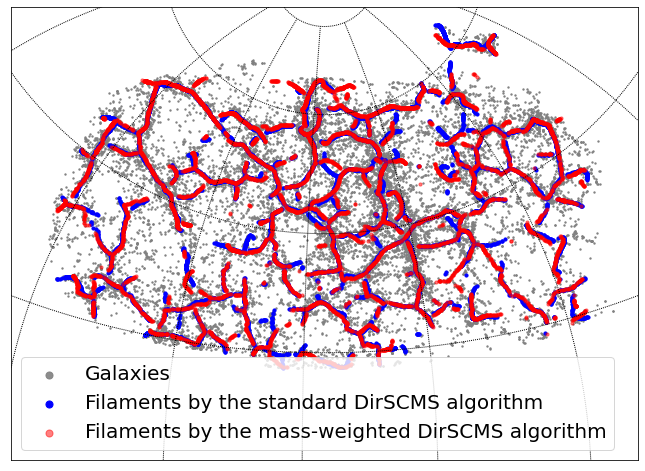

In [23]:
plt.rcParams.update({'font.size': 20})  ## Change the font sizes of ouput figures
fig = plt.figure(figsize=(10,8))
lon_p = gal_north_ang[:,0]
lat_p = gal_north_ang[:,1]
lon_m, lat_m, R = cart2sph(*DirModes_org.T)
lon_m[(lon_m >= -180) & (lon_m <= 0)] = lon_m[(lon_m >= -180) & (lon_m <= 0)] + 360
lon_f, lat_f, R = cart2sph(*DirFila_org.T)
lon_f[(lon_f >= -180) & (lon_f <= 0)] = lon_f[(lon_f >= -180) & (lon_f <= 0)] + 360

lon_mw, lat_mw, R = cart2sph(*DirModes_mw.T)
lon_mw[(lon_mw >= -180) & (lon_mw <= 0)] = lon_mw[(lon_mw >= -180) & (lon_mw <= 0)] + 360
lon_fw, lat_fw, R = cart2sph(*DirFila_mw.T)
lon_fw[(lon_fw >= -180) & (lon_fw <= 0)] = lon_fw[(lon_fw >= -180) & (lon_fw <= 0)] + 360
# m1 = Basemap(projection='npaeqd', boundinglat=20, lon_0=0, resolution='l')
m1 = Basemap(width=18000000, height=13000000, resolution='l', projection='stere', lat_ts=50, lat_0=30, lon_0=185)
m1.drawmeridians(np.arange(0, 360, 30))
m1.drawparallels(np.arange(-90, 90, 30))
x_p, y_p = m1(lon_p, lat_p)
x_m, y_m = m1(lon_m, lat_m)
x_f, y_f = m1(lon_f, lat_f)
x_mw, y_mw = m1(lon_mw, lat_mw)
x_fw, y_fw = m1(lon_fw, lat_fw)
cs = m1.scatter(x_p, y_p, color='grey', marker='o', s=2, alpha=0.9, label='Galaxies')
cs = m1.scatter(x_f, y_f, color='blue', marker='o', s=10, 
                label='Filaments by the standard DirSCMS algorithm')
cs = m1.scatter(x_fw, y_fw, color='red', marker='o', s=10, alpha=0.5, 
                label='Filaments by the mass-weighted DirSCMS algorithm')
# cs = m1.scatter(x_m, y_m, color='yellow', marker='o', s=15, label='Local Modes')

lgnd = plt.legend(loc='lower left', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.tight_layout()
# plt.title('Comparison between the standard and mass-weighted DirSCMS algorithms')
plt.savefig('./Figures/DirSCMS_mass_wt.jpg', bbox_inches="tight", dpi=150)

### Distances from galaxies to these two sets of filaments

In [17]:
def DistToFila(x, tar_fila):
    x = x.values
    in_pd = np.dot(tar_fila, x)
    in_pd[in_pd > 1] = 1
    in_pd[in_pd < -1] = -1
    return min(np.arccos(in_pd))

gal_Dir_dist_org = pd.DataFrame(gal_north_cart).apply(lambda x: DistToFila(x, tar_fila=DirFila_org), axis=1)
gal_Dir_dist_mw = pd.DataFrame(gal_north_cart).apply(lambda x: DistToFila(x, tar_fila=DirFila_mw), axis=1)

In [18]:
gal_north1['dist_DirFila'] = gal_Dir_dist_org.values*180/np.pi
gal_north1['dist_mwDirFila'] = gal_Dir_dist_mw.values*180/np.pi

/tmp/ipykernel_57843/2397172205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal_north1['dist_DirFila'] = gal_Dir_dist_org.values*180/np.pi
/tmp/ipykernel_57843/2397172205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal_north1['dist_mwDirFila'] = gal_Dir_dist_mw.values*180/np.pi


In [19]:
from scipy.stats import binned_statistic

def lineplot_witherrorbar(x, y, bins=15, color='red', capsize=5, elinewidth=1, label=None):
    mean, bin_edges, binnumber = binned_statistic(x, y, statistic='mean', bins=bins)
    std, bin_edges, binnumber = binned_statistic(x, y, statistic='std', bins=bins)
    cnt, bin_edges, binnumber = binned_statistic(x, y, statistic='count', bins=bins)
    
    bin_med = (bin_edges[:-1]+bin_edges[1:])/2
    cri = (cnt != 0)
    plt.scatter(bin_med[cri], mean[cri], color=color)
    plt.errorbar(bin_med[cri], mean[cri], yerr=std[cri]/np.sqrt(cnt[cri]), 
                 capsize=capsize, elinewidth=elinewidth, color=color, label=label)

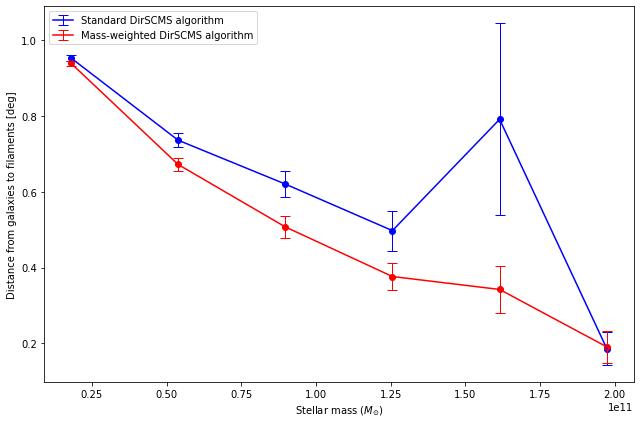

In [20]:
bins_edge = np.linspace(min(gal_north1.total_mass), max(gal_north1.total_mass), 7)

plt.figure(figsize=(9,6))
lineplot_witherrorbar(gal_north1.total_mass, gal_north1.dist_DirFila, 
                      bins=bins_edge, color='blue', capsize=5, elinewidth=1, label='Standard DirSCMS algorithm')
lineplot_witherrorbar(gal_north1.total_mass, gal_north1.dist_mwDirFila, 
                      bins=bins_edge, color='red', capsize=5, elinewidth=1, label='Mass-weighted DirSCMS algorithm')
plt.legend()
plt.ylabel('Distance from galaxies to filaments [deg]')
plt.xlabel('Stellar mass ($M_{\odot}$)')
plt.tight_layout()
plt.show()

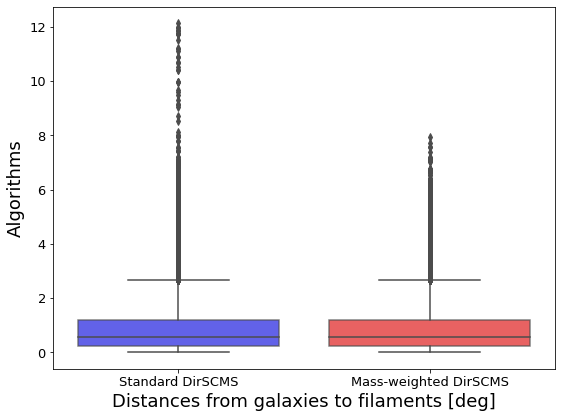

In [21]:
import seaborn as sns
fila_diff = pd.DataFrame({'Distances from galaxies to filaments (degree)': 180*np.concatenate([gal_Dir_dist_org, gal_Dir_dist_mw])/np.pi, 
                          'Methods': np.concatenate([np.repeat('Standard DirSCMS', gal_Dir_dist_org.shape[0]), 
                                                     np.repeat('Mass-weighted DirSCMS', gal_Dir_dist_mw.shape[0])])})

plt.rcParams.update({'font.size': 13})  ## Change the font sizes of ouput figures
plt.figure(figsize=(8,6))
my_pal = {Methods: "b" if Methods == "Standard DirSCMS" else "r" for Methods in fila_diff.Methods.unique()}
sns.boxplot(y="Distances from galaxies to filaments (degree)", x="Methods", data=fila_diff, 
            palette=my_pal, boxprops=dict(alpha=.7))
plt.xlabel('Distances from galaxies to filaments [deg]', fontsize=18)
plt.ylabel('Algorithms', fontsize=18)
plt.tight_layout()
plt.show()

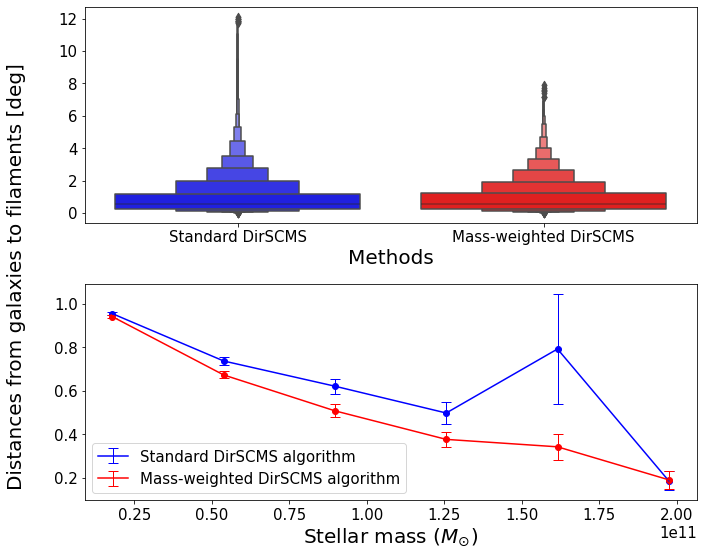

In [22]:
import seaborn as sns

plt.rcParams.update({'font.size': 15})  ## Change the font sizes of ouput figures
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
# fig.add_subplot(211)
fig = plt.figure(figsize=(10,8))
plt.subplot(211)
fila_diff = pd.DataFrame({'Distances from galaxies to filaments [deg]': 180*np.concatenate([gal_Dir_dist_org, gal_Dir_dist_mw])/np.pi, 
                          'Methods': np.concatenate([np.repeat('Standard DirSCMS', gal_Dir_dist_org.shape[0]), 
                                                     np.repeat('Mass-weighted DirSCMS', gal_Dir_dist_mw.shape[0])])})
my_pal = {Methods: "b" if Methods == "Standard DirSCMS" else "r" for Methods in fila_diff.Methods.unique()}
sns.boxenplot(y="Distances from galaxies to filaments [deg]", x="Methods", data=fila_diff, palette=my_pal)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('')

# fig.add_subplot(212)
plt.subplot(212)
bins_edge = np.linspace(min(gal_north1.total_mass), max(gal_north1.total_mass), 7)

lineplot_witherrorbar(gal_north1.total_mass, gal_north1.dist_DirFila, 
                      bins=bins_edge, color='blue', capsize=5, elinewidth=1, label='Standard DirSCMS algorithm')
lineplot_witherrorbar(gal_north1.total_mass, gal_north1.dist_mwDirFila, 
                      bins=bins_edge, color='red', capsize=5, elinewidth=1, label='Mass-weighted DirSCMS algorithm')
plt.legend()
plt.xlabel('Stellar mass ($M_{\odot}$)', fontsize=20)
fig.supylabel('Distances from galaxies to filaments [deg]', fontsize=20)
fig.tight_layout()
fig.savefig('./Figures/Dist_fila_mass_wt.pdf')
# plt.show()